In [128]:
%config InlineBackend.figure_formats = {"retina", "png"}
%matplotlib inline

import os

os.environ["OPENBLAS_NUM_THREADS"] = "1"

import numpy as np
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (4, 4)
plt.rcParams["font.size"] = 10

import superscreen as sc
from superscreen.geometry import box, circle, rotate
sc.version_table()

Software,Version
SuperScreen,0.12.1
Numpy,2.0.2
Numba,0.60.0
SciPy,1.13.1
matplotlib,3.9.4
IPython,8.18.1
Python,"3.9.0 (tags/v3.9.0:9cf6752, Oct 5 2020, 15:34:40) [MSC v.1927 64 bit (AMD64)]"
OS,nt [win32]
Number of CPUs,"Physical: 16, Logical: 22"
BLAS Info,Generic


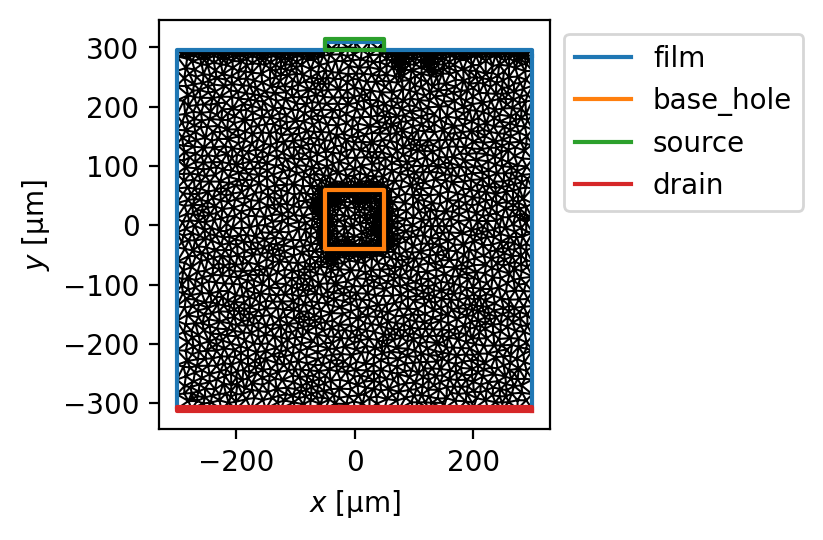

In [129]:
width = 600
height = 620
slot_height =20
slot_width = 250
x0, y0 = center = (0, 0)
length_units = "um"
slit_width=10
slit_height=540
hole_width=100
hole_height=100
layer=sc.Layer("base", Lambda=2.45)
film = sc.Polygon("film", layer="base", points=box(width, height))
slot = sc.Polygon(
    points=box(slot_width, slot_height, center=(-175,305))
    
)
film = film.difference(slot, slot.scale(xfact=-1))


drain_terminal = sc.Polygon(
    "drain", points=box(width, height / 100, center=(0,-height / 2))
)
source_terminal =  sc.Polygon(
    "source", points=box(100,20, center=(0, 305))
)

device = sc.Device(
    "constriction",
    layers=[layer],
    films=[film],
    terminals={film.name: [source_terminal, drain_terminal]},
    length_units=length_units,
)
device.holes = {
    "base_hole": sc.Polygon( "base_hole",layer="base", 
    points=box(hole_width, hole_height, center=(0,10)))
}

device.make_mesh(min_points=3000, smooth=0)
fig, ax = device.plot_mesh(edge_color="k", show_sites=False)
_ = device.plot_polygons(ax=ax, legend=True)
#fig, ax = device.draw(legend=True)

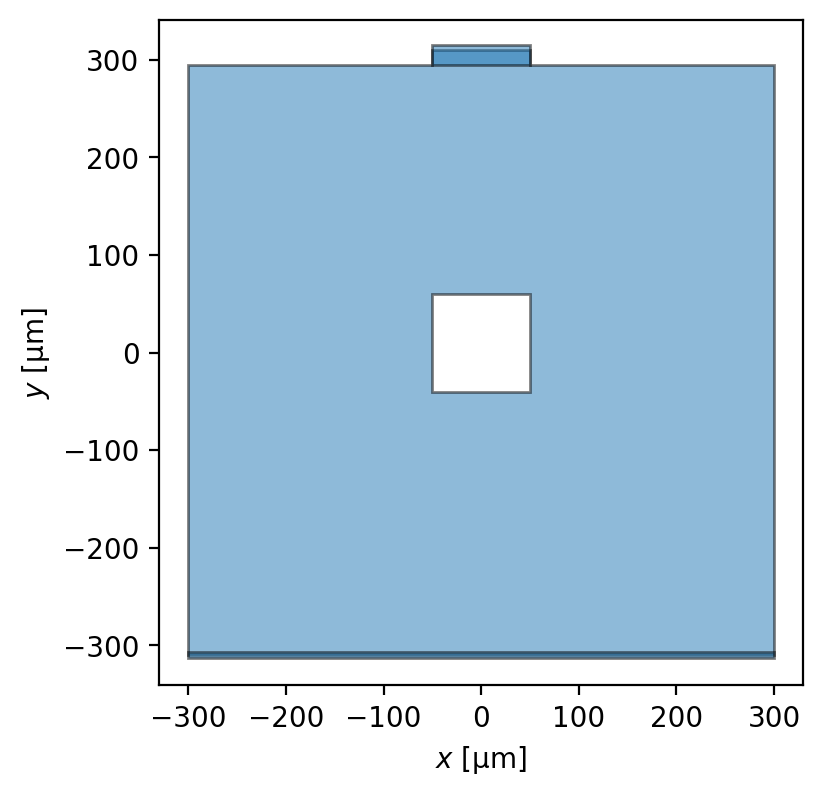

In [130]:
_=device.draw()

In [131]:
terminal_currents = {"film": {"source": "100 uA", "drain": "-100 uA"}}

solution = sc.solve(
    device,
    applied_field=sc.sources.ConstantField(0),
    terminal_currents=terminal_currents,
    current_units="uA",
)[-1]

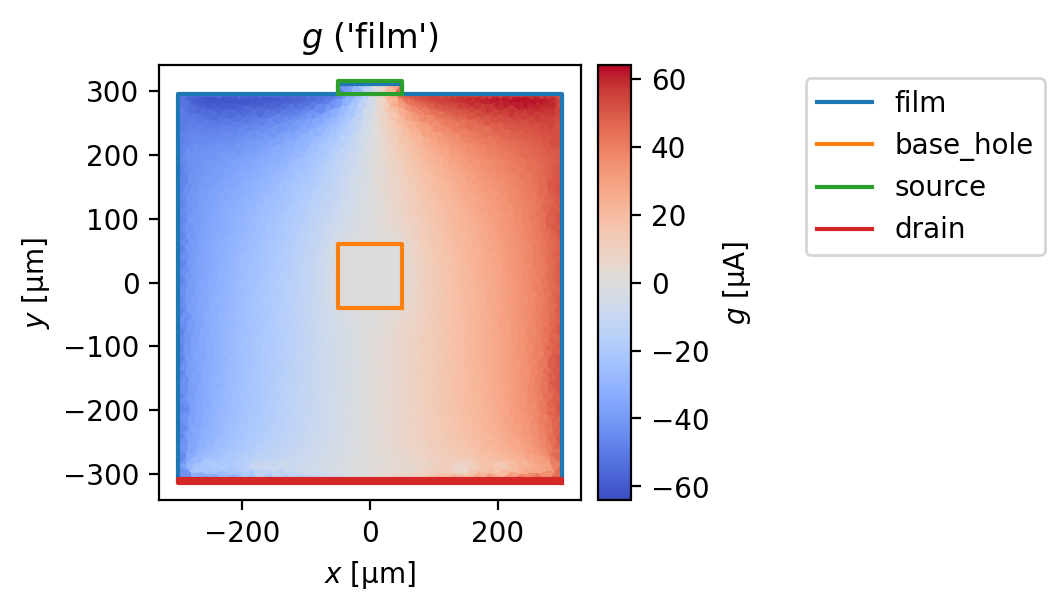

In [132]:
fig, axes = solution.plot_streams()
_ = device.plot_polygons(ax=axes[0])
_ = axes[0].legend(loc="upper left", bbox_to_anchor=(1.5, 1))

In [133]:
eval_region = sc.Polygon(points=box(150,50, center=(0, -300)))
eval_mesh = eval_region.make_mesh(max_edge_length=1.5)
def solve_and_plot_model(source_current="200 uA", applied_field="5 uT"):

    # Solve the model
    terminal_currents = {"film": {"source": source_current, "drain": f"-{source_current}"}}
    applied_field = sc.ureg(applied_field).to("uT").magnitude
    model = sc.factorize_model(
        device=device,
        terminal_currents=terminal_currents,
        current_units="uA",
    )
    solution = sc.solve(
        model=model,
        applied_field=sc.sources.ConstantField(applied_field),
        field_units="uT",
    )[-1]

    # # Uncomment to find the zero-fluxoid solution.
    # solution = sc.find_fluxoid_solution(
    #     model,
    #     applied_field=sc.sources.ConstantField(applied_field),
    #     field_units="uT",
    # )

    # Define cross sections
    xs = np.linspace(-600 / 2, +600/ 2, 501)
    ys = np.ones_like(xs)
    sections = [
        np.array([xs, -300 * ys]).T,
        np.array([xs, -200* ys]).T,
        np.array([xs, -100 * ys]).T,
        np.array([xs, 0.0 * ys]).T,
    ]

    # Plot currents.
    fig, axes = solution.plot_currents(
        streamplot=True,
        min_stream_amp=1e-4,
        cross_section_coords=sections,
        figsize=(5, 4),
        cmap="viridis",
        vmax=1,
        vmin=0,
    )
    
    _ = device.plot_polygons(ax=axes[0], lw=1, color="w", ls="--")

    # Evaluate the current through each cross section.
    for coords in sections:
        total_current = solution.current_through_path(coords, film="film", units="uA").magnitude
        target_current = abs(solution.terminal_currents["film"]["source"])
        err = abs(total_current - target_current) / abs(target_current) * 100
        print(
            f"Cross-section: y = {coords[0, 1]:.2f} um, total current = {total_current:.3f} uA,target current = {target_current:.3f} uA"
            f" ({err:.2f}% error)"
        )
    
    # Plot fields
    fig, ax = solution.plot_field_at_positions(
        eval_mesh,
        zs=0.25,
        cross_section_coords=sections,
        figsize=(5, 4),
    )
    for coords in sections:
        axes[0].plot(coords[:, 0], coords[:, 1], 'r--')
    _ = device.plot_polygons(ax=ax, lw=1, color="w", ls="--")
    print(solution)
    return solution
    

Cross-section: y = -300.00 um, total current = 769.185 uA,target current = 200.000 uA (284.59% error)
Cross-section: y = -200.00 um, total current = 75.425 uA,target current = 200.000 uA (62.29% error)
Cross-section: y = -100.00 um, total current = 333.431 uA,target current = 200.000 uA (66.72% error)
Cross-section: y = 0.00 um, total current = 66.704 uA,target current = 200.000 uA (66.65% error)


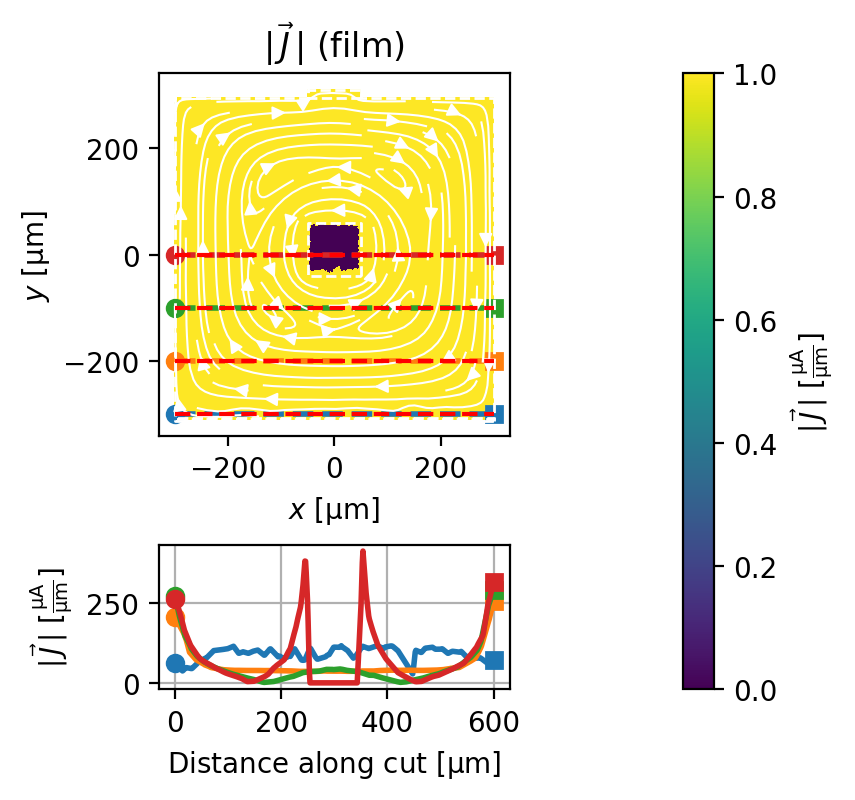

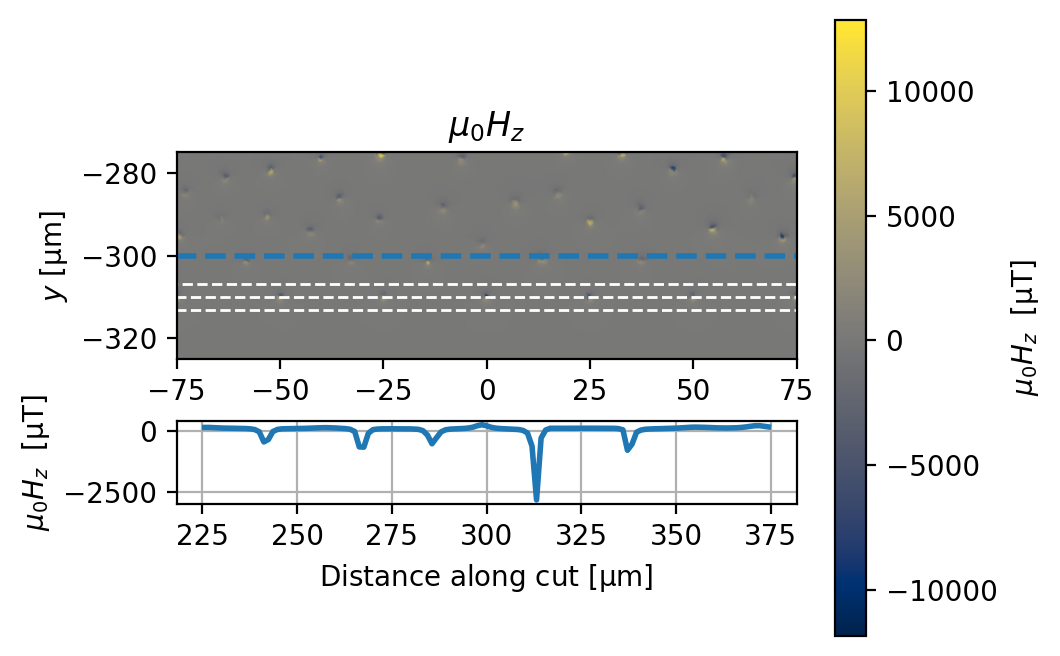

In [134]:
solution_0uT = solve_and_plot_model(source_current="200 uA", applied_field="50uT")

evice (Device) – The superscreen.Device

film_info (Dict[str, FilmInfo]) – A dict of {film_name: FilmInfo}

film_systems (Dict[str, LinearSystem]) – A dict of {film_name: LinearSystem}

hole_systems (Dict[str, Dict[str, LinearSystem]]) – A dict of {film_name: {hole_name: LinearSystem}}

terminal_systems (Dict[str, TerminalSystems]) – A dict of {film_name: TerminalSystems}

terminal_currents (Dict[str, Dict[str, float]]) – A dict of {film_name: {terminal_name: terminal_current}}

circulating_currents (Dict[str, float]) – A dict of {hole_name: circulating_current}

vortices (Dict[str, Sequence[Vortex]]) – A dict of {film_name: vortices}

current_units (str) – str

In [135]:
lambda_info=sc.solver.LambdaInfo(film=film,Lambda=400)

In [136]:
holem=sc.Polygon( "base_hole",layer="base", 
    points=box(hole_width, hole_height, center=(0,10)))

In [137]:
print(device.meshes.keys())

dict_keys(['film'])


In [138]:
from superscreen import fem

In [139]:
import numpy as np
num_mesh_points = len(device.meshes['film'].sites) # Get this from your film_info or device


hole_mesh=holem.make_mesh(min_points=3000, smooth=0)
print("hole_mesh shape:", hole_mesh.elements.shape)
Lambda = np.full(hole_mesh.sites.shape, fill_value=2.45) 
 # A 1D array of the desired value
print("Lambda shape:", Lambda.shape)

hole_mesh shape: (5910, 3)
Lambda shape: (3052, 2)


In [140]:
results_list = [hole_mesh.closest_site(site_element) for site_element in hole_mesh.sites]

# Convert the list of result ndarrays into a single combined ndarray
output_ndarray = np.array(results_list)
print("Output ndarray shape:", output_ndarray.shape)
re_list = [device.meshes['film'].closest_site(site_element) for site_element in device.meshes['film'].sites]

# Convert the list of result ndarrays into a single combined ndarray
interior_ndarray = np.array(re_list)
print("Output ndarray shape:", interior_ndarray.shape)


Output ndarray shape: (3052,)
Output ndarray shape: (3004,)


In [141]:
film_info=sc.solver.FilmInfo(
    name="nbn1",layer="base", vortices=None,interior_indices=interior_ndarray,
    boundary_indices=device.boundary_vertices(film.name),
    hole_indices={"base_hole":output_ndarray},
    lambda_info=sc.solver.LambdaInfo(film=film,Lambda=Lambda),
    in_hole=holem.make_mesh(min_points=3000, smooth=0),
    circulating_currents={ "base_hole", 100},
    terminal_currents=terminal_currents,
    weights=hole_mesh.vertex_areas,
    #laplacian=device.meshes['film'].Laplacian,
    kernel=sc.device.MeshOperators.Q_matrix(hole_mesh.sites, weights=hole_mesh.vertex_areas),
   laplacian =sc.fem.laplace_operator(hole_mesh.sites,hole_mesh.elements, hole_mesh.vertex_areas)
    )

In [148]:
factorize_linear_system=sc.solver.factorize_linear_systems(device,{"nbn1":film_info})

ValueError: illegal value in 4th argument of internal getrf (lu_factor)

In [ ]:
model1=sc.FactorizedModel(device, hole_systems=device.holes,film_info=film_info, terminal_currents = {"film": {"source": "100 uA", "drain": "-100 uA"}},
                          circulating_currents={"base_hole":"100 uA"},
                          current_units= "uA", vortices=None)



TypeError: __init__() missing 2 required positional arguments: 'film_systems' and 'terminal_systems'

In [ ]:
fluxoid=sc.fluxoid.make_fluxoid_polygons(device, holes='base_hole', join_style='mitre', interp_points=None)

AttributeError: 'dict' object has no attribute 'draw'

In [ ]:
fig, axes = fluxoid_solution.plot_streams(symmetric_color_scale=False, cmap="magma")
_ = device.plot_polygons(ax=axes[0], lw=2)
fig, axes = fluxoid_solution.plot_currents(streamplot=True)
_ = device.plot_polygons(ax=axes[0], lw=2)


In [ ]:
film_system=sc.solver.LinearSystem(
    A=sc.device.MeshOperators.Q_matrix(device.meshes['film'].sites, weights=device.meshes['film'].vertex_areas),
    indices=device.make_mesh(min_points=3000, smooth=0),
    
)